##Unsupervised Learning with Neural Networks
Here, I would like to look at different methods for unsupervised learning in neural networks. I focus on latent variable models where we have observed data $X$ and latent variables $Z$. Our purpose is to learn both a generative, $p_{\theta}(x|z)$, and a recognition model, $q_{\phi}(z|x)$ from the data. A good generative model will assign high probability to our observed data $X$. Therefore, we want to maximize $\log p_{\theta}(X)$ which can be written as  
$$
\log p_{\theta}(X) = \sum_{z} q_{\phi}(z|x) \log \frac{p_{\theta}(x,z)}{q_{\phi}(z|x)} + \sum_z q_{\phi}(z|x) \log \frac{q_{\phi}(z|x)}{p_{\theta}(z|x)} \\
= \mathcal{L}(\theta, \phi) + \text{KL}(q_{\phi}(z|x) || p_{\theta}(z|x))
$$
Since $\text{KL}(.||.)$ is always nonnegative, $\mathcal{L}(\theta, \phi)$ is a lower bound on log likelihood, i.e., $\mathcal{L}(\theta, \phi) \leq p_{\theta}(X)$. Therefore, we can maximize log likelihood by maximizing $\mathcal{L}(\theta, \phi)$ with respect to $\theta$ and $\phi$. Note that we can write $\mathcal{L}(\theta, \phi)$ as follows using $p_{\theta}(x,z) = p_{\theta}(x|z)p_{\theta}(z)$
$$
\mathcal{L}(\theta, \phi) = \sum_{z} q_{\phi}(z|x) \log \frac{p_{\theta}(x|z)}{q_{\phi}(z|x)} + \sum_{z} q_{\phi}(z|x) \log \frac{p_{\theta}(z)}{q_{\phi}(z|x)}
$$
This decomposition helps us see what maximizing $\mathcal{L}$ does. We see that the first term tries to bring the recognition and generative models closer to each other. While prior $p_{\theta}(z)$ acts as a regularizer for $q_{\phi}(z|x)$. (In the examples below, to keep things simple, we assume $p_{\theta}(z)$ is uniform.)

Let us calculate the derivatives of $\mathcal{L}$.
$$
\frac{\partial \mathcal{L}(\theta, \phi)}{\partial \theta} = \sum_{z} q_{\phi}(z|x) \nabla_{\theta} \log p_{\theta}(x,z) \\
= \mathbb{E}_{q}[\nabla_{\theta} \log p_{\theta}(x,z)]
$$
which can be approximated with samples from $q_{\phi}(z|x)$
$$
\frac{\partial \mathcal{L}(\theta, \phi)}{\partial \theta} \approx \frac{1}{L} \sum_{z_l \sim q} \nabla_{\theta} \log p_{\theta}(x,z_l)]
$$
Derivative with respect to $\phi$ is a bit more involved
$$
\frac{\partial \mathcal{L}(\theta, \phi)}{\partial \phi} = \sum_{z} \nabla_{\phi} q_{\phi}(z|x) \log \frac{p_{\theta}(x,z)}{q_{\phi}(z|x)} + q_{\phi}(z|x) \nabla_{\phi} \log \frac{p_{\theta}(x,z)}{q_{\phi}(z|x)} \\
= \sum_{z} \nabla_{\phi} q_{\phi}(z|x) \log \frac{p_{\theta}(x,z)}{q_{\phi}(z|x)} - \nabla_{\phi} q_{\phi}(z|x) \\
= \sum_{z} \nabla_{\phi} q_{\phi}(z|x) [\log p_{\theta}(x,z) - \log q_{\phi}(z|x) - 1] \\
$$
where we use $\sum_z \nabla q = \nabla \sum_z q = \nabla 1 = 0$ to get
$$
\frac{\partial \mathcal{L}(\theta, \phi)}{\partial \phi} = \sum_{z} \nabla_{\phi} q_{\phi}(z|x) [\log p_{\theta}(x,z) - \log q_{\phi}(z|x)] \\
$$
We can turn this into an expectation over $q_{\phi}(z|x)$ by using $\nabla_{\phi} q_{\phi}(z|x) = q_{\phi}(z|x) \nabla_{\phi} \log q_{\phi}(z|x)$ (Williams, 1992; Mnih and Gregor, 2014)
$$
\frac{\partial \mathcal{L}(\theta, \phi)}{\partial \phi} = \sum_{z} q_{\phi}(z|x) \nabla_{\phi} \log q_{\phi}(z|x) [\log p_{\theta}(x,z) - \log q_{\phi}(z|x)] \\
= \mathbb{E}_q [\nabla_{\phi} \log q_{\phi}(z|x) [\log p_{\theta}(x,z) - \log q_{\phi}(z|x)]
$$
Again, this can be approximated with samples from $q_{\phi}(z|x)$
$$
\frac{\partial \mathcal{L}(\theta, \phi)}{\partial \phi} \approx \frac{1}{L} \sum_{z_l \sim q} [\nabla_{\phi} \log q_{\phi}(z_l|x) [\log p_{\theta}(x,z_l) - \log q_{\phi}(z_l|x)]
$$

###Sampling with Neural Networks
We would like to model both $p(x|z)$ and $q(z|x)$ with neural networks. We need to be able to sample from these distributions and calculate probabilities. How can we represent a probability distribution with function approximators such as neural networks? There seems to be two ways to do it. We can assume a functional form for the distribution and let the neural network output the parameters of this distribution. Or we can include stochastic units in the network and let the network directly produce samples from the distribution. However, if we adopt the latter approach, it becomes difficult to calculate probability of a produced sample. Because we have no analytical expression for the probability of a sample (in contrast to the first approach where we assume a functional form), it is unclear how we can calculate for example $\nabla_{\phi} \log q_{\phi}$. Therefore, we adopt the first approach here and let the network outputs represent the parameters of the distribution.

Specifically, we model $p_{\theta}(x|z)$ and $q_{\phi}(z|x)$ with neural networks and assume $x \in \mathbb{R}^D$ and $z \in \mathbb{R}^K$. Networks output the means of the Gaussian distributions from which the outputs are sampled (one can easily extend this to output variances of the distributions as well). Using a simple one layer network,
$$
\mu_z = W_{\phi}x + b_{\phi} \\
z \sim N(\mu_z, \mathbf{I})
$$
and
$$
\mu_x = W_{\theta}z + b_{\theta} \\
x \sim N(\mu_x, \mathbf{I})
$$
We also assume $p_{\theta}(z) \propto 1$ for the sake of simplicity. One can in fact With the above expressions, it is straightforward to calculate the derivatives of $\mathcal{L}(\theta, \phi)$. 

Let us first generate some data to test our model.

In [86]:
# generate data
import numpy as np
import scipy.stats as stat

np.random.seed(123)
m1 = [4., 4., 4., 4.]
m2 = [-4., -4., -4. ,-4]
m3 = [-4., -4., 4. ,4]
m4 = [4., 4., -4. ,-4]
x1 = stat.multivariate_normal.rvs(m1, size=100)
x2 = stat.multivariate_normal.rvs(m2, size=100)
x3 = stat.multivariate_normal.rvs(m3, size=100)
x4 = stat.multivariate_normal.rvs(m4, size=100)
x = np.vstack([x1, x2, x3, x4])
y = np.zeros(400, dtype=np.int8)
y[100:200] = 1
y[200:300] = 2
y[300:400] = 3
# shuffle
rperm = np.random.permutation(400)
x = x[rperm]
y = y[rperm]

# randomly initialize parameters (we want all runs to start from the same initial parameters)
w_gen_init = np.random.randn(4, 2)
b_gen_init = np.random.randn(4)
w_rec_init = np.random.randn(2, 4)
b_rec_init = np.random.randn(2)

In [87]:
def calc_dl_dgen(xi, w_gen, b_gen, w_rec, b_rec, L=10):
    """Calculate derivative of L with respect to generative parameters
    Parameters:
        xi (ndarray): Training sample
        w_gen: Generative weights
        b_gen: Generative biases
        w_rec: Recognition weights
        b_rec: Recognition biases
        L: Number of samples used to estimate derivatives
    Returns:
        ndarray: Derivative of L wrt to generative weight matrix
        ndarray: Derivative of L wrt to generative biases
    """
    # run recognition network
    mu_zi = np.dot(w_rec, xi) + b_rec
    dl_dw_gen = 0.0
    dl_db_gen = 0.0
    for l in range(L):
        # latent sample
        zi = stat.multivariate_normal.rvs(mu_zi)
        # generate x from latent sample
        mu_xi = np.dot(w_gen, zi) + b_gen
        # calculate derivatives
        dl_dw_gen += np.outer((xi - mu_xi), zi)
        dl_db_gen += (xi - mu_xi)
    dl_dw_gen /= L
    dl_db_gen /= L
    return dl_dw_gen, dl_db_gen

def calc_dl_drec(xi, w_gen, b_gen, w_rec, b_rec, L=10):
    """Calculate derivative of L with respect to recognition parameters
    Parameters:
        xi (ndarray): Training sample
        w_gen: Generative weights
        b_gen: Generative biases
        w_rec: Recognition weights
        b_rec: Recognition biases
        L: Number of samples used to estimate derivatives
    Returns:
        ndarray: Derivative of L wrt to recognition weight matrix
        ndarray: Derivative of L wrt to recognition biases
    """
    # run recognition network
    mu_zi = np.dot(w_rec, xi) + b_rec
    dl_dw_rec = 0.0
    dl_db_rec = 0.0
    for l in range(L):
        # latent sample
        zi = stat.multivariate_normal.rvs(mu_zi)
        # run generation network
        mu_xi = np.dot(w_gen, zi) + b_gen
        # log p_{\theta}(x,z_l) - log q_{\phi}(z_l|x)
        d = np.sum(np.square(zi - mu_zi)) - np.sum(np.square(xi - mu_xi))
        dl_dw_rec += d*np.outer((zi - mu_zi), xi)
        dl_db_rec += d*(zi - mu_zi)
    dl_dw_rec /= L
    dl_db_rec /= L
    return dl_dw_rec, dl_db_rec

def calc_log_ll(x, w_gen, b_gen, w_rec, b_rec):
    log_ll = 0.0
    for i in range(x.shape[0]):
        xi = x[i]
        zp = np.dot(w_rec, xi) + b_rec
        xp = np.dot(w_gen, zp) + b_gen
        log_ll += -np.sum(np.square(xp - xi))
    return log_ll
    

In [88]:
w_gen_ga = w_gen_init.copy()  
b_gen_ga = b_gen_init.copy()  
w_rec_ga = w_rec_init.copy()  
b_rec_ga = b_rec_init.copy()  

np.random.seed(456)

epoch_count = 50
lr_gen = 1e-3
lr_rec = lr_gen * 1e-1

log_ll_ga = np.zeros(epoch_count+1)
log_ll_ga[0] = calc_log_ll(x, w_gen_ga, b_gen_ga, w_rec_ga, b_rec_ga)
print "Initial log ll: {0:f}".format(log_ll_ga[0])

dwrec_magnitude = np.zeros(x.shape[0])
for e in range(epoch_count):
    for i in range(x.shape[0]):
        xi = x[i]
        dwgen, dbgen = calc_dl_dgen(xi, w_gen_ga, b_gen_ga, w_rec_ga, b_rec_ga, 1)
        w_gen_ga += lr_gen * dwgen
        b_gen_ga += lr_gen * dbgen
        dwrec, dbrec = calc_dl_drec(xi, w_gen_ga, b_gen_ga, w_rec_ga, b_rec_ga, 1)
        w_rec_ga += lr_rec * dwrec
        b_rec_ga += lr_rec * dbrec  
        
        dwrec_magnitude[i] = np.sum(np.square(dwrec))

    log_ll_ga[e+1] = calc_log_ll(x, w_gen_ga, b_gen_ga, w_rec_ga, b_rec_ga)
    print "Epoch {0:d}, log ll: {1:f}, grad w_rec magnitude: {2:f}+-{3:f}".format(e+1, log_ll_ga[e+1], 
                                                                                  np.mean(dwrec_magnitude), 
                                                                                  np.std(dwrec_magnitude))

Initial log ll: -214423.600882
Epoch 1, log ll: -2679.703192, grad w_rec magnitude: 490063.752972+-4474610.140355
Epoch 2, log ll: -1898.383248, grad w_rec magnitude: 4538.782673+-22227.025987
Epoch 3, log ll: -1724.315127, grad w_rec magnitude: 2909.973653+-9066.120164
Epoch 4, log ll: -1419.938889, grad w_rec magnitude: 2228.684838+-8971.839582
Epoch 5, log ll: -1346.953244, grad w_rec magnitude: 1801.508805+-6142.404225
Epoch 6, log ll: -1327.014637, grad w_rec magnitude: 1800.588749+-4846.572510
Epoch 7, log ll: -1304.538066, grad w_rec magnitude: 1460.173830+-4721.073453
Epoch 8, log ll: -1179.396913, grad w_rec magnitude: 1546.307060+-5395.629405
Epoch 9, log ll: -1204.776319, grad w_rec magnitude: 1392.174493+-5892.342840
Epoch 10, log ll: -1164.279473, grad w_rec magnitude: 1156.830348+-3608.556234
Epoch 11, log ll: -1179.183926, grad w_rec magnitude: 1246.189479+-6182.716679
Epoch 12, log ll: -1155.492940, grad w_rec magnitude: 1641.821522+-5180.592394
Epoch 13, log ll: -1127.

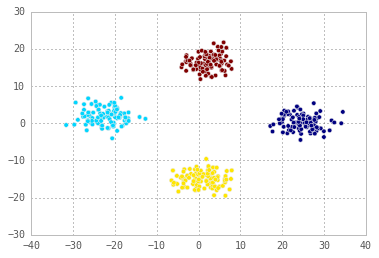

In [89]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_z(x, y, w_rec, b_rec):
    z = np.zeros((x.shape[0], 2))
    for i in range(x.shape[0]):
        xi = x[i]
        zi = np.dot(w_rec, xi) + b_rec
        z[i] = zi
    plt.scatter(z[:,0], z[:,1], c=y)
    
plot_z(x, y, w_rec_ga, b_rec_ga)

### Reparameterization Trick
(Kingma and Welling, 2014)

In [90]:
def calc_dl_drec_reparameterized(xi, w_gen, b_gen, w_rec, b_rec, L=10):
    """Calculate derivative of L with respect to recognition parameters using the reparameterization trick
    Parameters:
        xi (ndarray): Training sample
        w_gen: Generative weights
        b_gen: Generative biases
        w_rec: Recognition weights
        b_rec: Recognition biases
        L: Number of samples used to estimate derivatives
    Returns:
        ndarray: Derivative of L wrt to recognition weight matrix
        ndarray: Derivative of L wrt to recognition biases
    """
    # run recognition network
    mu_zi = np.dot(w_rec, xi) + b_rec
    dl_dw_rec = 0.0
    dl_db_rec = 0.0
    for l in range(L):
        # latent sample
        zi = stat.multivariate_normal.rvs(mu_zi)
        # run generation network
        mu_xi = np.dot(w_gen, zi) + b_gen
        # calculate derivatives
        dl_dw_rec += np.dot(w_gen.T, np.outer((xi - mu_xi), xi))
        dl_db_rec += np.dot(w_gen.T, (xi - mu_xi))
    dl_dw_rec /= L
    dl_db_rec /= L
    return dl_dw_rec, dl_db_rec


In [91]:
w_gen_rt = w_gen_init.copy()  
b_gen_rt = b_gen_init.copy()  
w_rec_rt = w_rec_init.copy()  
b_rec_rt = b_rec_init.copy()  

np.random.seed(456)

epoch_count = 50
lr_gen = 1e-3
lr_rec = lr_gen * 1e-1

log_ll_rt = np.zeros(epoch_count+1)
log_ll_rt[0] = calc_log_ll(x, w_gen_rt, b_gen_rt, w_rec_rt, b_rec_rt)
print "Initial log ll: {0:f}".format(log_ll_rt[0])

dwrec_magnitude = np.zeros(x.shape[0])
for e in range(epoch_count):
    for i in range(x.shape[0]):
        xi = x[i]
        dwgen, dbgen = calc_dl_dgen(xi, w_gen_rt, b_gen_rt, w_rec_rt, b_rec_rt, 1)
        w_gen_rt += lr_gen * dwgen
        b_gen_rt += lr_gen * dbgen
        dwrec, dbrec = calc_dl_drec_reparameterized(xi, w_gen_rt, b_gen_rt, w_rec_rt, b_rec_rt, 1)
        w_rec_rt += lr_rec * dwrec
        b_rec_rt += lr_rec * dbrec    
        
        dwrec_magnitude[i] = np.sum(np.square(dwrec))

    log_ll_rt[e+1] = calc_log_ll(x, w_gen_rt, b_gen_rt, w_rec_rt, b_rec_rt)
    print "Epoch {0:d}, log ll: {1:f}, grad w_rec magnitude: {2:f}+-{3:f}".format(e+1, log_ll_rt[e+1], 
                                                                                  np.mean(dwrec_magnitude), 
                                                                                  np.std(dwrec_magnitude))

Initial log ll: -214423.600882
Epoch 1, log ll: -2872.324900, grad w_rec magnitude: 1297.670903+-6322.578550
Epoch 2, log ll: -2226.228444, grad w_rec magnitude: 221.712860+-258.888008
Epoch 3, log ll: -1991.762158, grad w_rec magnitude: 158.306376+-189.957230
Epoch 4, log ll: -1722.999310, grad w_rec magnitude: 146.618283+-168.241610
Epoch 5, log ll: -1632.541089, grad w_rec magnitude: 113.000465+-131.129674
Epoch 6, log ll: -1640.971201, grad w_rec magnitude: 96.057553+-110.256589
Epoch 7, log ll: -1506.310142, grad w_rec magnitude: 82.249741+-94.770960
Epoch 8, log ll: -1419.869064, grad w_rec magnitude: 67.051020+-74.665611
Epoch 9, log ll: -1393.248663, grad w_rec magnitude: 66.516352+-77.573888
Epoch 10, log ll: -1346.378436, grad w_rec magnitude: 59.588850+-65.065625
Epoch 11, log ll: -1334.726374, grad w_rec magnitude: 57.214613+-68.900979
Epoch 12, log ll: -1280.067112, grad w_rec magnitude: 48.317147+-52.426200
Epoch 13, log ll: -1250.908925, grad w_rec magnitude: 48.860174+-

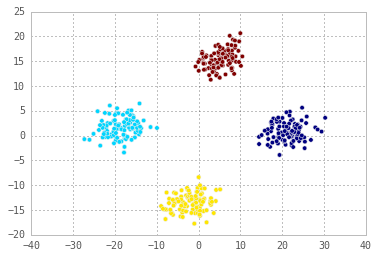

In [92]:
plot_z(x, y, w_rec_rt, b_rec_rt)

### Wake-sleep Algorithm